# Introduction to Digital Signal Processing and Data Analysis

In many cases one does not know before hand what is the frequency of the harmonic that needs to be filtered when setting up a measurement system, or the sensor starts drifting over time creating low frequency oscillations.  Luckily it is possible to remove the noise component in a post processing manner using the principles of signal processing.  Here we are going to only see a few aspects of this very exciting tool.  We are going to first start with creating our own digital filters using FFT, then we will use built-in functions to do real filters, like Butterworth.  Finally, we will see some other tools that will be useful to interpret data.

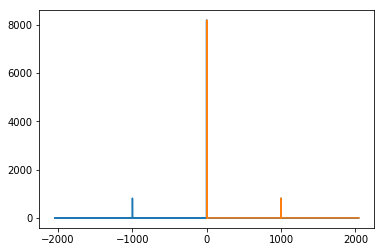

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

Ts = 1
fs = 2**12
timestep = 1/fs
N = Ts*fs
t = numpy.arange(0,Ts,timestep)
f_t = 4*numpy.sin(2*numpy.pi*2*t-numpy.pi/4)+0.4*numpy.sin(2*numpy.pi*1000*t)
sp = numpy.fft.fft(f_t) # compute FFT 

freq = numpy.fft.fftfreq(N, d=timestep)

pyplot.plot(freq, abs(sp));

freq1 = freq[range(int(fs/2))]
sp1 = sp[range(int(fs/2))]
pyplot.plot(freq1,abs(sp1));

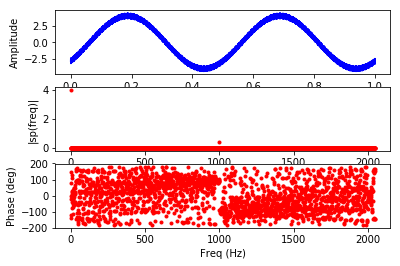

In [3]:
#frq = numpy.arange(int(fs))
#frq = frq[range(int(fs/2))] # one side frequency range
#sp = sp[range(int(fs/2))]
phase = numpy.arctan2(sp.imag,sp.real)

fig, ax = pyplot.subplots(3, 1)
ax[0].plot(t,f_t,'b-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(freq1,abs(sp1)*2/N,'r.') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|sp(freq)|')
ax[2].plot(freq1,phase[range(int(fs/2))]*180/numpy.pi,'r.') # plotting the spectrum
ax[2].set_xlabel('Freq (Hz)')
ax[2].set_ylabel('Phase (deg)');

The phase does not look good because we are dividing 0/0 where there are no harmonics. Let's set the fft/phase there to 0 to remove this numerical artifact.

In [4]:
epsilon = 1e-8
low_values_flags = abs(sp) < epsilon  # Where values are low
sp[low_values_flags] = 0

phase2 = numpy.arctan2(sp.imag,sp.real)
#phase2[low_values_flags]=0

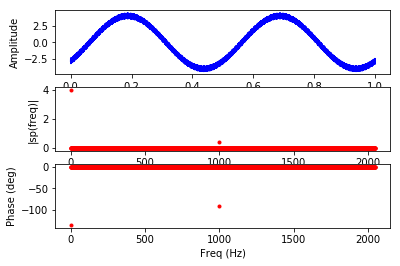

In [5]:
fig, ax = pyplot.subplots(3, 1)
ax[0].plot(t,f_t,'b-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(freq1,abs(sp1)*2/N,'r.') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|sp(freq)|')
ax[2].plot(freq1,phase2[range(int(fs/2))]*180/numpy.pi,'r.') # plotting the spectrum
#ax[2].plot(frq,phase*180/numpy.pi*sp,'r.') # plotting the spectrum
ax[2].set_xlabel('Freq (Hz)')
ax[2].set_ylabel('Phase (deg)');

## 'Ideal' Filters with FFT

The data are filtered in Fourier space by setting frequencies of interest to 0 and keeping the other frequencies.  The procedure is as follow:
> 1- take FFT of temporal data of interest

> 2- create a mask: set frequencies we wish to keep at 1, the ones we wish to remove to 0

> 3- multiply the FFT by the mask

> 4- recover the filtered temporal data by taking the inverse FFT of the masked spectrum.

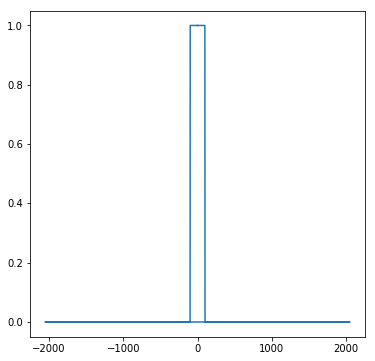

In [6]:
LPF = numpy.zeros(len(freq))

fc = 100
LP_flags = abs(freq) < fc
LPF[LP_flags] = 1

fig = pyplot.figure(figsize=(6,6))
pyplot.plot(freq,LPF);


Let's apply this to the original spectra.

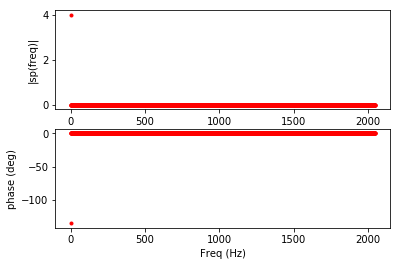

In [7]:
sp_LPF = sp*LPF
phase_LPF = numpy.arctan2(sp_LPF.imag,sp_LPF.real)

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(freq1,abs(sp_LPF[range(int(fs/2))])*2/N,'r.')
ax[0].set_ylabel('|sp(freq)|')
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('phase (deg)')
ax[1].plot(freq1,phase_LPF[range(int(fs/2))]*180/numpy.pi,'r.');

reconstruct filtered signal.

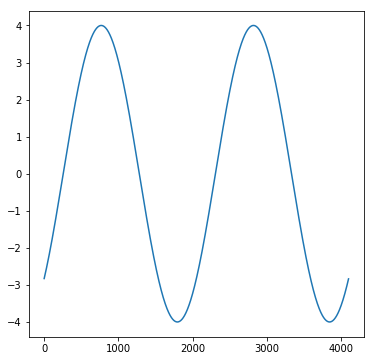

In [8]:
f_t_LPF = numpy.fft.ifft(sp_LPF)
fig = pyplot.figure(figsize=(6,6))
pyplot.plot(f_t_LPF.real);

Let's now look into 2D data by using images contaminated with noise and see how to correct for it.  Imaging is a case where it is difficult if not impossible to do many types of signal conditioning beyond what is within the camera.  Fortunately, there exists a broad range of digital image processing tools that we can use.

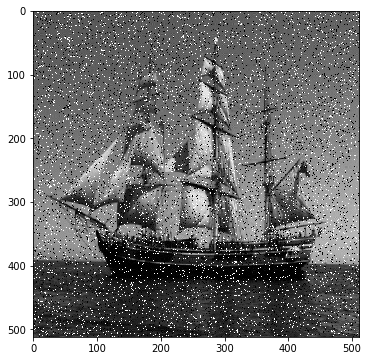

In [9]:
import imageio
image = imageio.imread('img/NoisyShip.png')
fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(image, cmap='gray');

The image above is contaminated by a high frequency (small spatial pattern) random noise called ''salt and pepper'' noise.  Let's look at the spectra of this image.

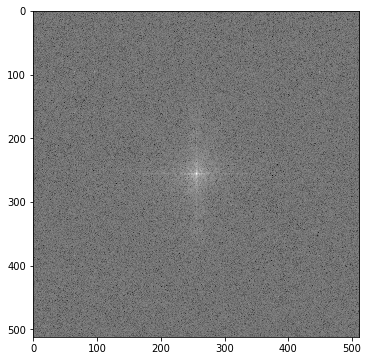

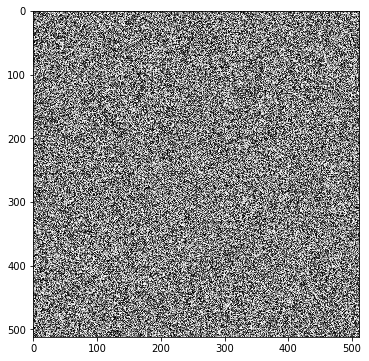

In [10]:
FF = numpy.fft.fft2(image)
FF_s = numpy.fft.fftshift(FF)

phase = numpy.arctan2(FF.imag,FF.real)
phase_s = numpy.fft.fftshift(phase)

fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(numpy.log(abs(FF_s)), cmap ='gray');

fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(phase_s, cmap ='gray');

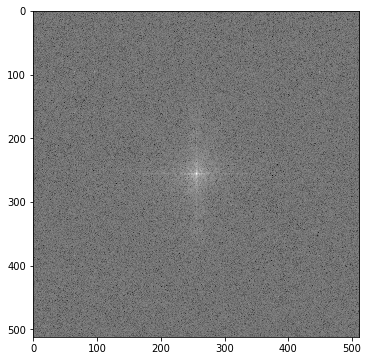

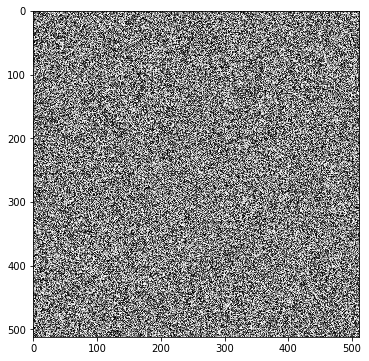

In [11]:
epsilon = 1e-8
low_values_flags = abs(FF) < epsilon  # Where values are low
FF[low_values_flags] = 0

FF_s = numpy.fft.fftshift(FF)

phase = numpy.arctan2(FF.imag,FF.real)
phase_s = numpy.fft.fftshift(phase)

fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(numpy.log(abs(FF_s)), cmap ='gray');

fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(phase_s, cmap ='gray');

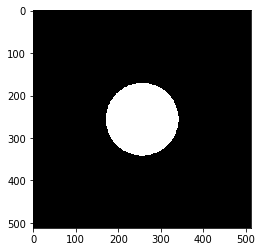

In [12]:
# Let's define a mask to remove the high frequency noise
dims = image.shape
mask = numpy.zeros(dims)
r = dims[0]/2/3
xc = dims[0]/2
yc = dims[1]/2

for x in range(dims[0]-1):
    for y in range(dims[1]-1):
        if (x-xc)**2+(y-yc)**2 < r**2:
            mask[x,y]=1

pyplot.imshow(mask,cmap='gray')
pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


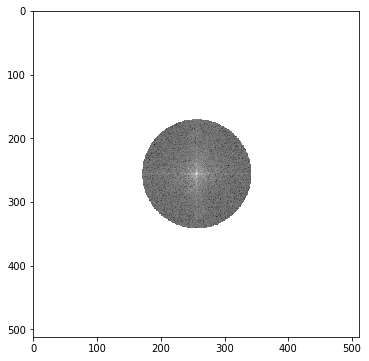

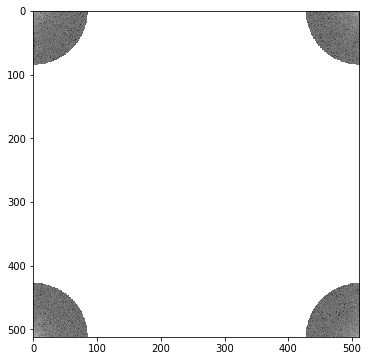

In [13]:
# Let's apply the mask to the shifted FFT of the image

FF_s_LPF = FF_s*mask

fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(numpy.log(abs(FF_s_LPF)), cmap ='gray');

FF_LPF = numpy.fft.ifftshift(FF_s_LPF)
fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(numpy.log(abs(FF_LPF)), cmap ='gray');

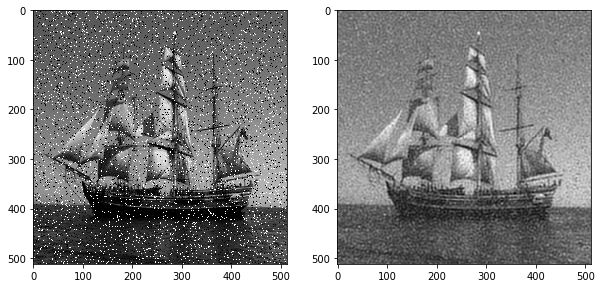

In [14]:
image_LPF = numpy.fft.ifft2(FF_LPF)
fig,ax = pyplot.subplots(1,2,figsize=(10,10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_LPF.real, cmap ='gray');

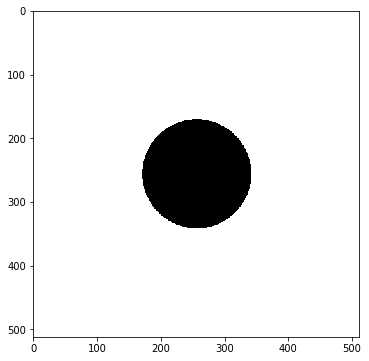

In [15]:
# we can also define a high pass filter to only keep the salt and pepper noise.
mask_HPF = 1 - mask
fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(mask_HPF, cmap ='gray');

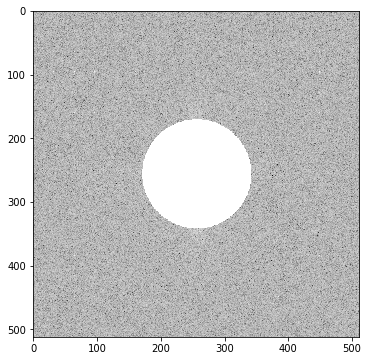

In [16]:
FF_s_HPF = FF_s*mask_HPF

fig = pyplot.figure(figsize=(6,6))
pyplot.imshow(numpy.log(abs(FF_s_HPF)), cmap ='gray');

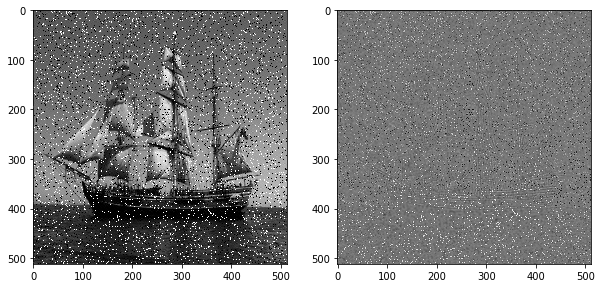

In [17]:
FF_HPF = numpy.fft.ifftshift(FF_s_HPF)
image_HPF = numpy.fft.ifft2(FF_HPF)
fig,ax = pyplot.subplots(1,2,figsize=(10,10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_HPF.real, cmap ='gray');

## Butterworth filters
Let's do Butterworth filters:

We will use the built-in functions of the signal processing libraries of python.


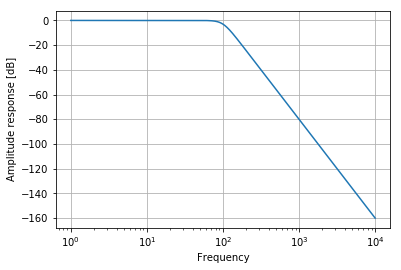

In [20]:
from scipy import signal

b, a = signal.iirfilter(4, [100], 1, 60, analog=True, btype='lowpass',ftype='butter')
w, h = signal.freqs(b, a, worN=numpy.logspace(0, 4, 1000))
pyplot.semilogx(w, 20 * numpy.log10(abs(h)))
pyplot.xlabel('Frequency')
pyplot.ylabel('Amplitude response [dB]')
pyplot.grid()
pyplot.show()

Let's apply this to a noisy dataset.  Here we will introduce two new concepts in the data: harmonic is not constant (changes in time) and there is random noise.

The function (without) random noise is:
\begin{align*}
x (t) = 1.0\sin(2\pi 0.75 t(1-t) + 2.1) +
0.1 \sin (2 \pi 1.5t + 1) + 0.18 \cos(2 \pi 3.75 t)
\end{align*}

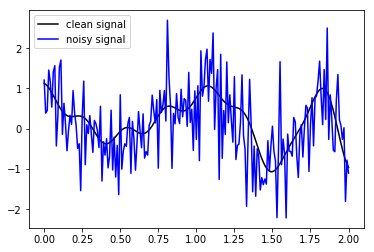

In [21]:
N1 = 201
t1_0 = 0
t1_1 = 2
t1 = numpy.linspace(t1_0,t1_1,N1)
x = 1.0*numpy.sin(2*numpy.pi*0.75*t1*(1-t1) + 2.1) +\
0.1*numpy.sin(2*numpy.pi*1.5*t1 + 1) +\
0.18*numpy.cos(2*numpy.pi*3.75*t1)
noise = numpy.random.randn(len(t1)) * 0.8
xn = x + noise

pyplot.figure
pyplot.plot(t1,x,'k');
pyplot.plot(t1,xn,'b');
pyplot.legend(('clean signal','noisy signal'), loc='best');

Let's look at the spectra of this filter

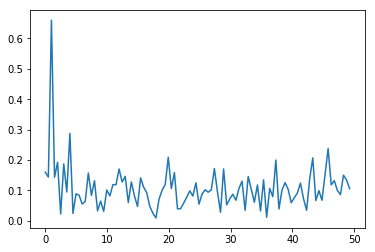

In [22]:
sp_xn = numpy.fft.fft(xn) # compute FFT 
timestep1 = (t1_1-t1_0)/(N1-1)
freq1 = numpy.fft.fftfreq(N1, d=timestep1)

pyplot.plot(freq1[range(int(N1/2))],abs(sp_xn[range(int(N1/2))])*2/N1);

Note: this is different than what we are used to...

Let's replot the spectra removing the random noise component.

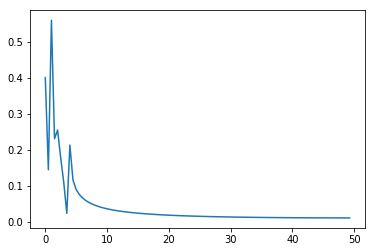

In [23]:
sp_x = numpy.fft.fft(x) # compute FFT 

pyplot.plot(freq1[range(int(N1/2))],abs(sp_x[range(int(N1/2))])*2/N1);

Ok.  This looks more like signal we are used to analyse so far, except for the time varying harmonic, which is spread over a broad range of frequencies.  Let's look at the spectra of the noise by itself.

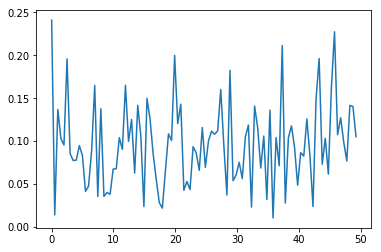

In [24]:
sp_noise = numpy.fft.fft(noise) # compute FFT 

pyplot.plot(freq1[range(int(N1/2))],abs(sp_noise[range(int(N1/2))])*2/N1);

Random noise has a uniform spectrum...  We won't be able to entirely filter it out.  One can see it better by increasing the number of samples. 

Let's now apply a digital filter to it and see if we can filter some of the noise.

In [46]:
# This is a low pass Butterworth filter of order 8 and fc =15.
n_order = 8
fs1 = 1/timestep1 # Sampling frequency (Hz)
fc = 10 # Cuttoff frequency (Hz)
print(fs1, fc)
b, a = signal.iirfilter(n_order, [fc/fs1], analog=False, btype='lowpass',ftype='butter')


100.0 10


Let's apply the filter to $x_n$, use lfilter_zi to choose the initial condition of the filter:

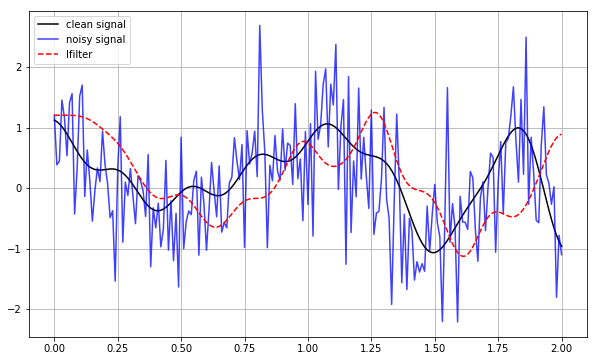

In [47]:
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, xn, zi=zi*xn[0])
pyplot.figure(figsize=(10,6))
pyplot.plot(t1, x, 'k')
pyplot.plot(t1, xn, 'b', alpha=0.75)
pyplot.plot(t1, z, 'r--')
pyplot.legend(('clean signal','noisy signal', 'lfilter'), loc='best')
pyplot.grid(True)
pyplot.show()

We can recognize some of the features of Butterworth low-pass filters: the filtered signal lags the original.

> Play with the order and cutoff frequency and see how this affects the filtered signal.



Python has a function that allows to filter the data without introducing lags, 'filtfilt'.  Its order is twice the order selected for the original function, so we are going to apply the Butterwort filter a second time to compare the two functions.

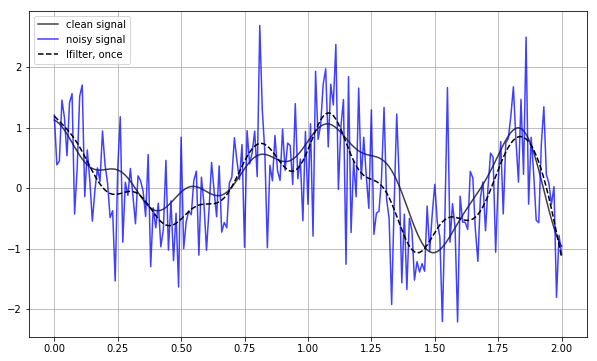

In [48]:
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, xn)

pyplot.figure(figsize=(10,6))
pyplot.plot(t1, x, 'k', alpha=0.75)
pyplot.plot(t1, xn, 'b', alpha=0.75)
#pyplot.plot(t1, z, 'r--')
#pyplot.plot(t1, z2, 'b--')
pyplot.plot(t1, y, 'k--')
pyplot.legend(('clean signal','noisy signal','lfilter, once','lfilter, twice','filtfilt'), loc='best')
pyplot.grid(True)
pyplot.show()

Let's see what effect the filters had on the spectra.


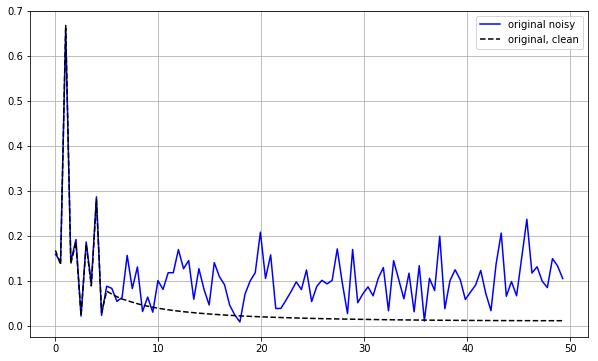

In [49]:
sp_z2 = numpy.fft.fft(z)
sp_y = numpy.fft.fft(y)

pyplot.figure(figsize=(10,6))
pyplot.plot(freq1[range(int(N1/2))],abs(sp_xn[range(int(N1/2))])*2/N1,'b')
#pyplot.plot(freq1[range(int(N1/2))],abs(sp_x[range(int(N1/2))])*2/N1,'k')
#pyplot.plot(freq1[range(int(N1/2))],abs(sp_z2[range(int(N1/2))])*2/N1,'r--')
pyplot.plot(freq1[range(int(N1/2))],abs(sp_y[range(int(N1/2))])*2/N1,'k--')
pyplot.legend(('original noisy','original, clean','lfilter, twice','filtfilt'), loc='best')
pyplot.grid(True)
pyplot.show()

Let's compare to the results of the 'ideal' spectral filter we created earlier. 

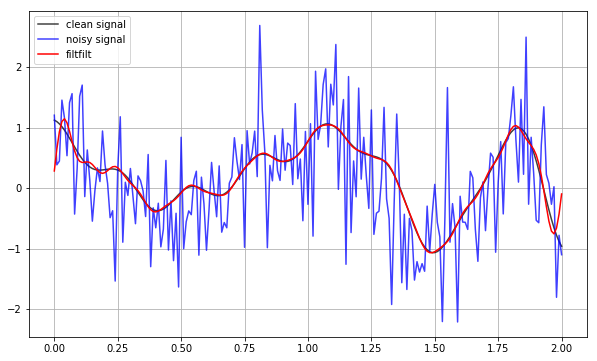

In [50]:
LPF1 = numpy.zeros(len(freq1))
LP1_flags = abs(freq1) < fc
LPF1[LP1_flags] = 1

sp_x_LPF1 = sp_x*LPF1

xn_t_LPF = numpy.fft.ifft(sp_x_LPF1)

pyplot.figure(figsize=(10,6))
pyplot.plot(t1, x, 'k', alpha=0.75)
pyplot.plot(t1, xn, 'b', alpha=0.75)
#pyplot.plot(t1, y, 'k--', alpha=0.75)
pyplot.plot(t1, xn_t_LPF.real,'r')
pyplot.legend(('clean signal','noisy signal','filtfilt','FFT filt'), loc='best')
pyplot.grid(True)
pyplot.show()

What are the most notable differences between the filtering schemes?


## Time domain filtering

All the filters we have seen so far were spectrally based, i.e. we were removing a frequency component of the signal.  Here we are going to see a simple series of function to do filtering in the time domain.  The easiest one is the moving or running average function.  It is useful to prepare data prior to processing and in some cases more relevant than spectral methods.  For your information, with some assumptions behind, it is used extensively in the financial industry for forecasting.

The moving average is defined as:

\begin{align*}
x_{trail,i} = \frac{1}{2N+1} \sum_{j=0}^{2N} x_{i-j}
\end{align*}

In this definition $x_i$ is based on the past $2(N+1)$ values of the variable $x$.  It will trail or lag the trend.

It can also be defined based on the surrounding values.

\begin{align*}
x_{center,i} = \frac{1}{2N+1} \sum_{j=-N}^{N} x_{i-j}
\end{align*}

While this can be easily programmed (and some functions such as smooth do it automatically), the moving average is really a convolution of a kernels of 1 of length N with the original data.  For discrete data, the convolution is the mathematical operation:

\begin{align*}
\left( f \ast g \right)[i] = \sum_{j=-N}^{N} f[i-j]g[j]
\end{align*}

For a centered moving average, the function $g$ is referred as the kernel.  It is $g = [1, 1, \dots , 1]/(2N+1)$.  Using the convolution function enables to switch to different kernels.

Let's apply the moving average function to the time series data $x_n$.

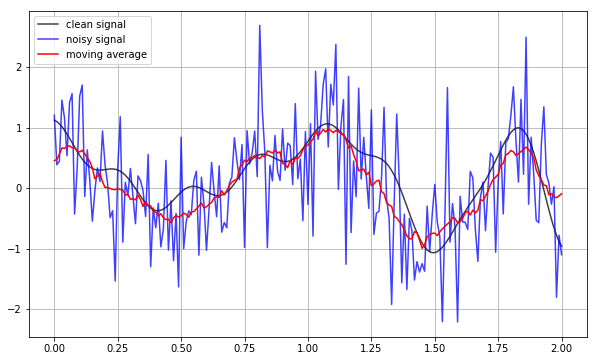

In [58]:
N = 8 # in the notation convention here, we will have a kernel of 2N+1 points

kernel = numpy.ones(((2*N+1),))/(2*N+1)
xn_MA = numpy.convolve(xn, kernel, mode='same')

pyplot.figure(figsize=(10,6))
pyplot.plot(t1, x, 'k', alpha=0.75)
pyplot.plot(t1, xn, 'b', alpha=0.75)
pyplot.plot(t1, xn_MA,'r')
pyplot.legend(('clean signal','noisy signal','moving average'), loc='best')
pyplot.grid(True)
pyplot.show()

Let's discuss the resulting data.

> Change the value of $N$ and see how you recover the signal.  

> What happens when the number of points become too large?

Let's now see a Gaussian filter.  The kernel has to be replaced by a Gaussian distribution of standard deviation $\sigma$.

[-3 -2 -1  0  1  2  3]


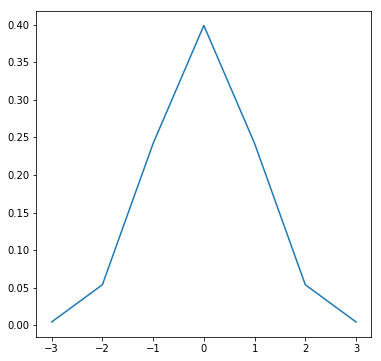

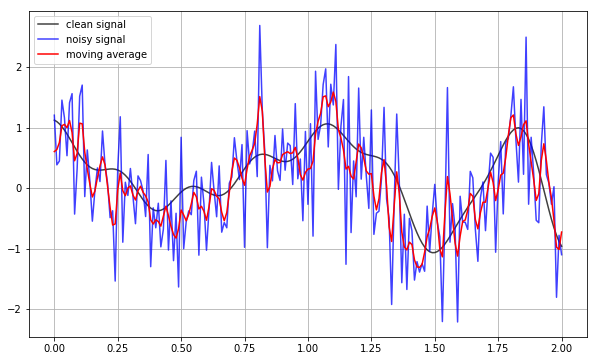

In [61]:
sigma = 1
xt = numpy.arange(-3*sigma,3*sigma+1,1)
print(xt)
kernel = 1/numpy.sqrt(2*numpy.pi*sigma**2)*numpy.exp(-xt**2/2*sigma**2)
xn_MA = numpy.convolve(xn, kernel, mode='same')

pyplot.figure(figsize=(6,6))
pyplot.plot(xt,kernel)


pyplot.figure(figsize=(10,6))
pyplot.plot(t1, x, 'k', alpha=0.75)
pyplot.plot(t1, xn, 'b', alpha=0.75)
pyplot.plot(t1, xn_MA,'r')
pyplot.legend(('clean signal','noisy signal','moving average'), loc='best')
pyplot.grid(True)
pyplot.show()

## Other tools of time-series

To illustrate other tools of time series analysis we will reuse a module from your engineering computation on global earth temperature.  If you remember from your engineering computation class one is more interested in the temperature anomaly.

Here are the data.

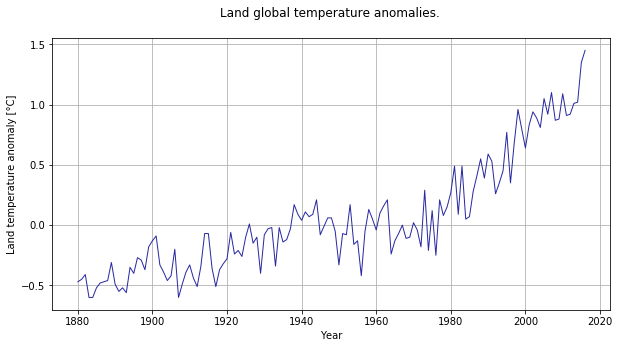

In [62]:
fname = 'data/land_global_temperature_anomaly-1880-2016.csv'
year, temp_anomaly = numpy.loadtxt(fname, delimiter=',', skiprows=5, unpack=True)

pyplot.figure(figsize=(10,5))
#Plotting
pyplot.plot(year, temp_anomaly, color='#2929a3', linestyle='-', linewidth=1)
pyplot.title('Land global temperature anomalies. \n')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.grid();

One of the thing you did in your engineering computation class was to plot a trend line on the data.  From there we would hope to be able to estimate if the temperature rise that we can observe on this curve will increase or not.  

Before doing a regression, let's first smooth the data: let's remove the high frequency fluctuations and help us determine if there is an underlying trend.  From the tools you have developed so far, how would you propose we do this?



Let's do it first in the time domain:

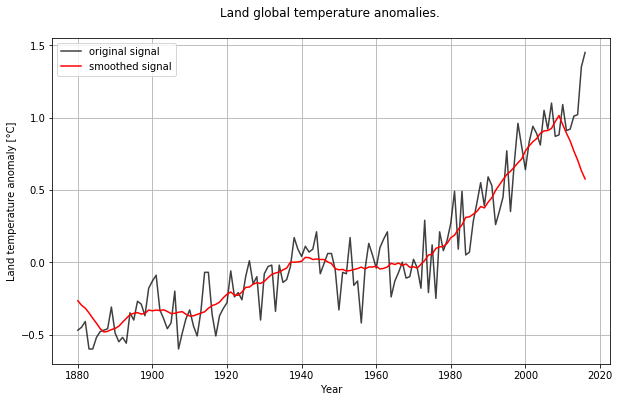

In [63]:
N = 7 # in the notation convention here, we will have a kernel of 2N+1 points
kernel = numpy.ones(((2*N+1),))/(2*N+1)
temp_anomaly_MA = numpy.convolve(temp_anomaly, kernel, mode='same')

pyplot.figure(figsize=(10,6))
pyplot.plot(year, temp_anomaly, 'k', alpha=0.75)
pyplot.plot(year, temp_anomaly_MA,'r')
pyplot.legend(('original signal','smoothed signal'), loc='best')
pyplot.title('Land global temperature anomalies. \n')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.grid();

Now we can see that there is a (complex) trend in the data!

Let's do a linear regression of the data and try to get the global trend.



In [64]:
# calculate polynomial coefficient
z = numpy.polyfit(year, temp_anomaly, 1)

# create polynomial equation
f = numpy.poly1d(z)
print(f)

 
0.01037 x - 20.15


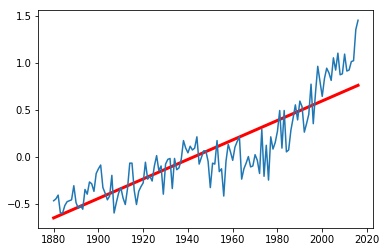

In [65]:
# calculate fitted values
temp_anomaly_fit = f(year)
 
# Plot outputs
pyplot.plot(year, temp_anomaly_fit, color='red',linewidth=3)
pyplot.plot(year, temp_anomaly);

0.22697753331895595


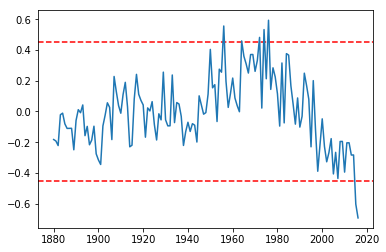

In [66]:
# Residuals
residuals = temp_anomaly_fit - temp_anomaly

# add two lines for +- 2 sigma
sigma_residuals = numpy.std(residuals)
print(sigma_residuals)

pyplot.axhline(y=2*sigma_residuals, color='r', linestyle='--')
pyplot.axhline(y=-2*sigma_residuals, color='r', linestyle='--')
pyplot.plot(year, residuals);

Let's analyze this plot:

> Are the residuals correlated or random?  How would you chek for randomness?

> Do you detect any outliers?  How would you define an outlier?

We will need to define a statistics to identify outliers.

## Autos and cross-correlations

Using data above let's identify if the data are correlated.  To do this, we will use a tool called the auto-correlation function, $R_{yy}$.  It is related to the convolution seen above.  It is a function of the lag, $\tau$:

\begin{align*}
R_{yy}(\tau) = \sum_{i=0}^N y(i)\overline{y(i-\tau)}
\end{align*}
with $\overline{y}$ the complex conjugate of $y$.

The autocorrelation function is a convolution $y(t)$ with $y(-t)$:
\begin{align*}
R_{yy}(\tau) = y(t) \ast \overline{y(-t)}
\end{align*}


The autocorrelation function is normalized by the standard deviation of the distribution to give the autocorrelation coefficients.
\begin{align*}
\rho_{yy}(l) = \frac{R_{yy}(l)}{\sigma_{y}^2} = \frac{\sum_n y(n)y(n-l)}{\sigma_y^2}
\end{align*}
Once normalized, $\rho$ takes values between -1 and +1.

In [ ]:
acf = numpy.correlate(residuals, residuals,"full")
acf2 = numpy.correlate(residuals, residuals)
acc = acf/acf2

N_lags = len(temp_anomaly)
lags = numpy.linspace(-N_lags-1,N_lags-1,num = 2*N_lags-1)

pyplot.plot(lags,acc)
pyplot.xlabel('lag (year)')
pyplot.ylabel('ACC of residuals')
pyplot.axhline(y=2*sigma_residuals, color='r', linestyle='--')
pyplot.axhline(y=-2*sigma_residuals, color='r', linestyle='--')
pyplot.grid();

### Regression correction for correlated data
linear regressions rely on the fact that the residuals are random and independent.

In practice

We will now see how we can estimate a trend for the global temperature anomalies, taking into account that the data are not independent.  There are several approaches; we will see an “easy” one, the Cochrane-Orcutt for autocorrelation correction.  In this procedure, the fitted value, $Y_i$, is a function of $Y_{i-1}$, $X_i$, $X_{i-1}$, instead of just being dependent on $X_i$ for linear regressions:

\begin{align*}
Y_i= r Y_{i-1} + a (1-r) + b (x_i - r x_{i-1} )+ \epsilon_i
\end{align*}

Where $r$ is the autocorrelation coefficient at lag 1 of the residuals; $a$ and $b$ are two constant parameters that need to be determined.  Here are the steps for this procedure.


### Fast convolution algorithm



\begin{array}{l l l}
f(t) & F(\omega) & \text{property}\\
\hline
\alpha f_1(t) + \beta f_2(t) & \alpha F_1(\omega) + \beta F_2(\omega) & \text{linearity}\\
f(t-t_0) & F(\omega)e^{-i\omega t_0} & \text{time shifting}\\
f(t)e^{i\omega_0 t} & F(\omega - \omega_0) & \text{frequency shifting}\\
f(at) & \frac{1}{|a|} F(\frac{\omega}{a}) & \text{time scaling}\\
\frac{df}{dt} & i\omega F(\omega) & \text{differentiation}\\
\int_{\infty}^t f(\tau) d\tau & \pi F(0) \delta(\omega) + \frac{1}{i \omega} F(\omega) & \text{integration}\\
f_e(t) & Re[F(\omega)] = A(\omega) & \text{even signal}\\
f_o(t) & i Im[F(\omega)] = i B(\omega) & \text{odd signal}\\
f_1(t) f_2(t) & \frac{1}{2\pi} F_1(\omega) * F_2(\omega) & \text{multiplication}\\
f_1(t) * f_2(t) & F_1(\omega)  F_2(\omega) & \text{convolution}
\end{array}

## Outliers

\begin{align*}
\tau = \frac{t_{\alpha /2} (n-1)}{\sqrt{n} \sqrt{n-2+t_{\alpha /2}^2}}
\end{align*}

<img src="img/Thompson-tau.png" width="360">